### Age-structured SEkIkIkR model, compared to COVID-19 data in UK

In this example, we fit the parameter $\beta$ of an SEkIkIkR model to epidemiological data from the UK; **all other parameters for the SEkIkIkR model are chosen ad-hoc.**

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../..')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
plt.rcParams.update({'font.size': 22})

### Load age structure and contact matrices for UK

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()

# matrix of total contacts
C=CH+CW+CS+CO

### Load and visualise epidemiological data for UK

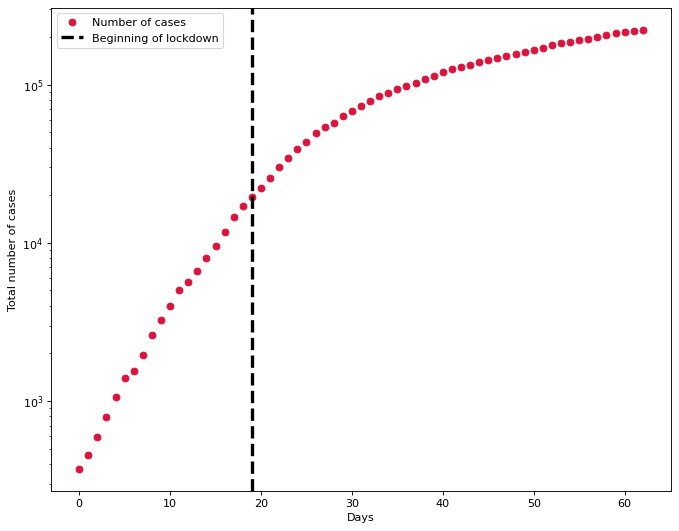

In [5]:
# Load data
my_data = np.genfromtxt('../data/covid-cases/uk.txt', delimiter='', skip_header=7)
cases = my_data[:,1]

# data starts on 2020-03-03
# The lockdown in the UK started on 2020-03-23, which corresponds to the 20th datapoint
# (which has index 19)
lockdown_start = 19

fig,ax = plt.subplots(1,1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
ax.plot(cases,marker='o',ls='',color='crimson',
        label='Number of cases')
ax.axvline(lockdown_start,
           lw=3,ls='--',color='black',
           label='Beginning of lockdown')
ax.set_xlabel('Days')
ax.set_ylabel('Total number of cases')
ax.set_yscale('log')
ax.legend(loc='best')
plt.show()
plt.close()

Note that
* the data is shown in a semilogarithmic plot, and that
* this is the total number of cases, not the active cases.

### Define parameters and initial condition of SEkIkIkR model

In [6]:
alpha= 0.3              # fraction of asymptomatics
gE   = 1/2.72            # recovery rate of exposeds
kI   = 10;               # # of stages of I class
kE   = 10;                # # of stages of E class 
gIa  = 1./7              # recovery rate of asymptomatic infectives 
gIs  = 1./17.76          # recovery rate of symptomatic infectives
fsa  = 0.5              # fraction of symptomatics who self-isolate



# We start with one symptomatic infective in each of the age groups 6-13,
# let the model "grow the number of infectives" by itself,
# and will later define a reference point to relate the 
# time of the simulation to the real time of the UK data.
S0 = np.zeros(M)  
I0 = np.zeros((kI,M));
E0 = np.zeros((kE,M));
for i in range(kI):
    I0[i, 6:13]= 1
for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i]) - np.sum(E0[:,i])
I0 = np.reshape(I0, kI*M)/kI;
E0 = np.reshape(E0, kE*M)/kE;



# the contact structure is independent of time 
def contactMatrix(t):
    return C


# duration of simulation and data file
Tf=200;  Nf = Tf+1

# We use the first 20 days (= pre lockdown data) of the 
# UK dataset for the fit
# note that day 20 has index 19
Tf_fit = 19; Nf_fit = Tf_fit+1;
cases_fit = cases[:Tf_fit+1]


def findBetaIs(x,
               reference_index=0):
    # reference_index = index of the UK time series which we use as "anchor"
    #                   for relating simulation time and time of UK time series.
    #
    # Define model and run simulation
    parameters = {'beta':x, 'gE':gE, 'gIa':gIa, 'gIs':gIs,
                  'kI':kI, 'kE' : kE, 'fsa':fsa, 'alpha':alpha}
    model = pyross.deterministic.SEkIkIkR(parameters, M, Ni)
    data=model.simulate(S0, E0,  0*I0, I0.copy(), 
                        contactMatrix, Tf, Tf+1)
    #
    # The UK time series gives all known cases (NOT just the currently active ones)
    # To get these from the simulation, we use
    # (All known cases) = (Total population) - (# of suspectibles) + (# of asymptomatics),
    # which assumes that the asymptomatics do not count as known cases,
    # and that all symptomatics are registered as "known cases".
    Ia = (model.Ia(data))
    summedAgesIa = Ia.sum(axis=1)
    S = (model.S(data))
    summedAgesS = S.sum(axis=1)
    trajectory = N - summedAgesS + summedAgesIa
    #
    # We shift the simulated trajectory such that reference_index-th datapoint
    # of the UK trajectory agrees well with a datapoint on the simulated trajectory:
    index = np.argmin( np.fabs( trajectory - cases[reference_index]) )
    # index = "which point of simulated trajectory agrees well with UK data at reference_index?"
    numerical_arr = trajectory[index-reference_index:index-reference_index+Nf_fit]
    #
    # this if-clause rules out unrealistic parameters that lead to an "index" too
    # far to the end of the trajectory:
    if np.shape(cases_fit) != np.shape(numerical_arr):
        return np.inf 
    #
    # calculate mean-squared deviation between simulated trajectory and given dataset
    diff = (cases_fit-numerical_arr)
    error = np.sum( diff**2 )
    return error
    

    
''' 
# implement same fitting procedure also for assumption 
# "both asymptomatic and symptomatic cases count as known cases"?
def findBetaIsandIa(x):    
    parameters = {'beta':x, 'gE':gE, 'gIa':gIa, 'gIs':gIs,
                  'kI':kI, 'kE' : kE, 'fsa':fsa, 'alpha':alpha}
    model = pyross.deterministic.SEkIkIkR(parameters, M, Ni)

    data=model.simulate(S0, E0,  0*I0, I0.copy(), 
                        contactMatrix, Tf_fit, Nf_fit)
    
    Is = (model.Is(data))
    summedAgesIs = Is.sum(axis=1)
    Ia = (model.Ia(data))
    summedAgesIa = Ia.sum(axis=1)
    summedAgesI = summedAgesIs + summedAgesIa
    
    index = np.argmin( np.fabs( summedAgesI - cases[0]) )
    numerical_arr = summedAgesIs[index:index+Nf_fit]
    
    if np.shape(cases_fit) != np.shape(numerical_arr):
        return np.inf
    
    error = np.sum(( cases_fit-numerical_arr)**2)
    return error
''';

### Find optimal value of $\beta$

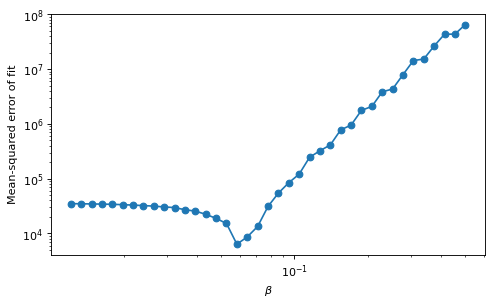

starting guess for minimiser: 0.058210321777087126


In [7]:
# scan parameter space to find good initial value for minimiser

beta_arr = np.logspace(-2,-0.3,num=41)
values = np.zeros_like(beta_arr)
for i,beta in enumerate(beta_arr):
    values[i] = findBetaIs(beta)

# visualise
fig,ax = plt.subplots(1,1, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
ax.plot(beta_arr,np.sqrt(values),marker='o')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Mean-squared error of fit')
plt.show()
plt.close()

min_beta = beta_arr [ np.argmin( values) ]
print('starting guess for minimiser:',min_beta)

In [8]:
beta0  = min_beta

# we use the datapoint at the beginning of the lockdown as reference
reference_index = 19

# define function for minimiser and run minimisation
minimising_func = lambda x: findBetaIs(x,reference_index)
sol1 = optimize.root(minimising_func,beta0) 
print('Is only best fit: ', sol1.x)

Is only best fit:  [0.05984224]


Array index for simulated trajectory on 2020-03-03: 19


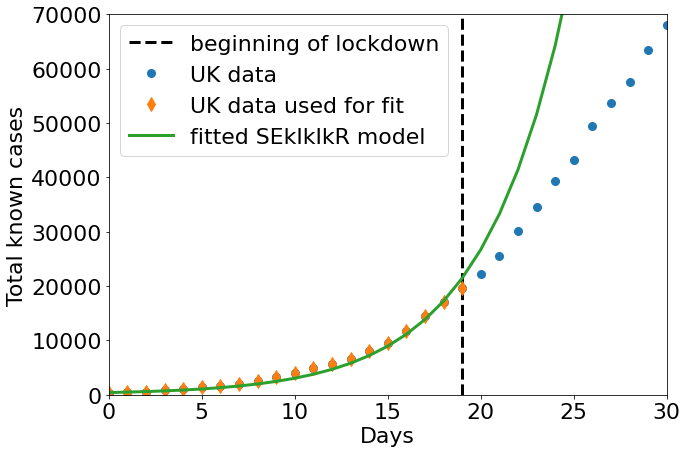

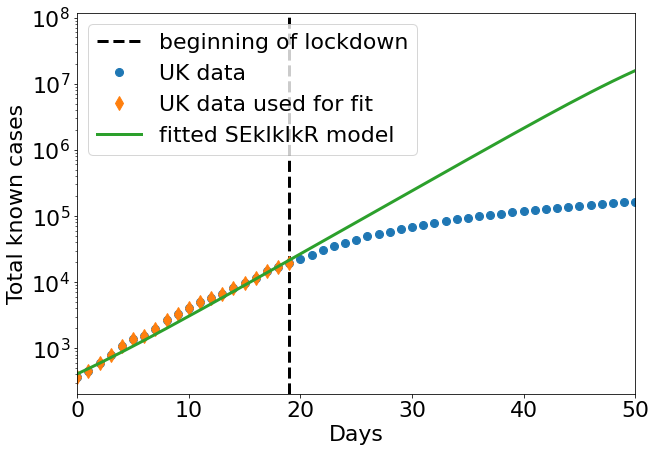

In [12]:
x=sol1.x[0]
parameters = {'beta':x, 'gE':gE, 'gIa':gIa, 'gIs':gIs,
                  'kI':kI, 'kE' : kE, 'fsa':fsa, 'alpha':alpha}
model = pyross.deterministic.SEkIkIkR(parameters, M, Ni)

data=model.simulate(S0, E0,  0*I0, I0.copy(),  contactMatrix, Tf, Nf)


plt.rcParams.update({'font.size': 22})
# Compare total number of cases to dataset used for fitting

# As in the function used for fitting, we use
# (All known cases) = (Total population) - (# of suspectibles) + (# of asymptomatics),
Ia = (model.Ia(data))
summedAgesIa = Ia.sum(axis=1)
S = (model.S(data))
summedAgesS = S.sum(axis=1)
trajectory = N - summedAgesS + summedAgesIa

# Relate time of simulation to time of dataset used for fitting
# (as in function "findBetaIs" used for fitting)
index = np.argmin( np.fabs( trajectory - cases[reference_index]) )
print('Array index for simulated trajectory on 2020-03-03:',index-reference_index)


fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.axvline(Tf_fit,lw=3,ls='--',
           color='black',label='beginning of lockdown')
ax.plot(cases,marker='o',ls='',markersize=8,
       label='UK data')
ax.plot(cases_fit,marker='d',ls='',markersize=10,
               label='UK data used for fit')
ax.plot(trajectory[index-reference_index:],lw=3,
       label='fitted SEkIkIkR model')
ax.set_xlabel('Days')
ax.set_ylabel('Total known cases')
ax.set_ylim(0,7e4)
ax.set_xlim(0,30)
ax.legend(loc='best')
#ax.set_yscale('log')
fig.savefig('fitParamBeta_UK.pdf',bbox_inches='tight')
plt.show()
plt.close(fig)



fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.axvline(Tf_fit,lw=3,ls='--',
           color='black',label='beginning of lockdown')
ax.plot(cases,marker='o',ls='',markersize=8,
       label='UK data')
ax.plot(cases_fit,marker='d',ls='',markersize=10,
               label='UK data used for fit')
ax.plot(trajectory[index-reference_index:],lw=3,
       label='fitted SEkIkIkR model')
ax.set_xlabel('Days')
ax.set_ylabel('Total known cases')
ax.set_xlim(0,50)
ax.legend(loc='best')
ax.set_yscale('log')
plt.show()
plt.close(fig)